In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
#import scanorama
import json
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

### Глобальные переменные

In [2]:
qc_palette = sns.color_palette(['red', 'gray'])

# Подгрузим файлы

In [3]:
# Define paths and get sample_ids
file_list = os.listdir('../data/raw_spatial_data/human/')
file_list

['human_759', 'human_j12', 'human_j3', 'human_j4', 'human_j6']

In [4]:
file = 'human_j6'

In [5]:
# аннотация слоёв
ann = pd.read_csv('../data/clusters/' + file + '.csv', index_col=0)
ann.columns = ['label']
ann.head()

label
Barcode                        
AAACAAGTATCTCCCA-1           WM
AAACAGCTTTCAGAAG-1  Empty spots
AAACATTTCCCGGATT-1           WM
AAACCCGAACGAAATC-1           WM
AAACCGGGTAGGTACC-1           L2

In [6]:
# каунты секвенирования
adata = sc.read_visium('../data/raw_spatial_data/human/'+ file)
adata.var_names_make_unique()
adata.obs['label'] = ann.label
adata.obs['sample_id'] = file

reading ..\data\raw_spatial_data\human\human_j6\filtered_feature_bc_matrix.h5
 (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# adata

## Посчитаем метрики

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['hb'] = adata.var_names.str.contains(("^HB[AB]"))
adata.var['ribo'] = adata.var_names.str.contains(("^RP[LS]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt','hb','ribo'],
    percent_top=None, log1p=False, inplace=True)

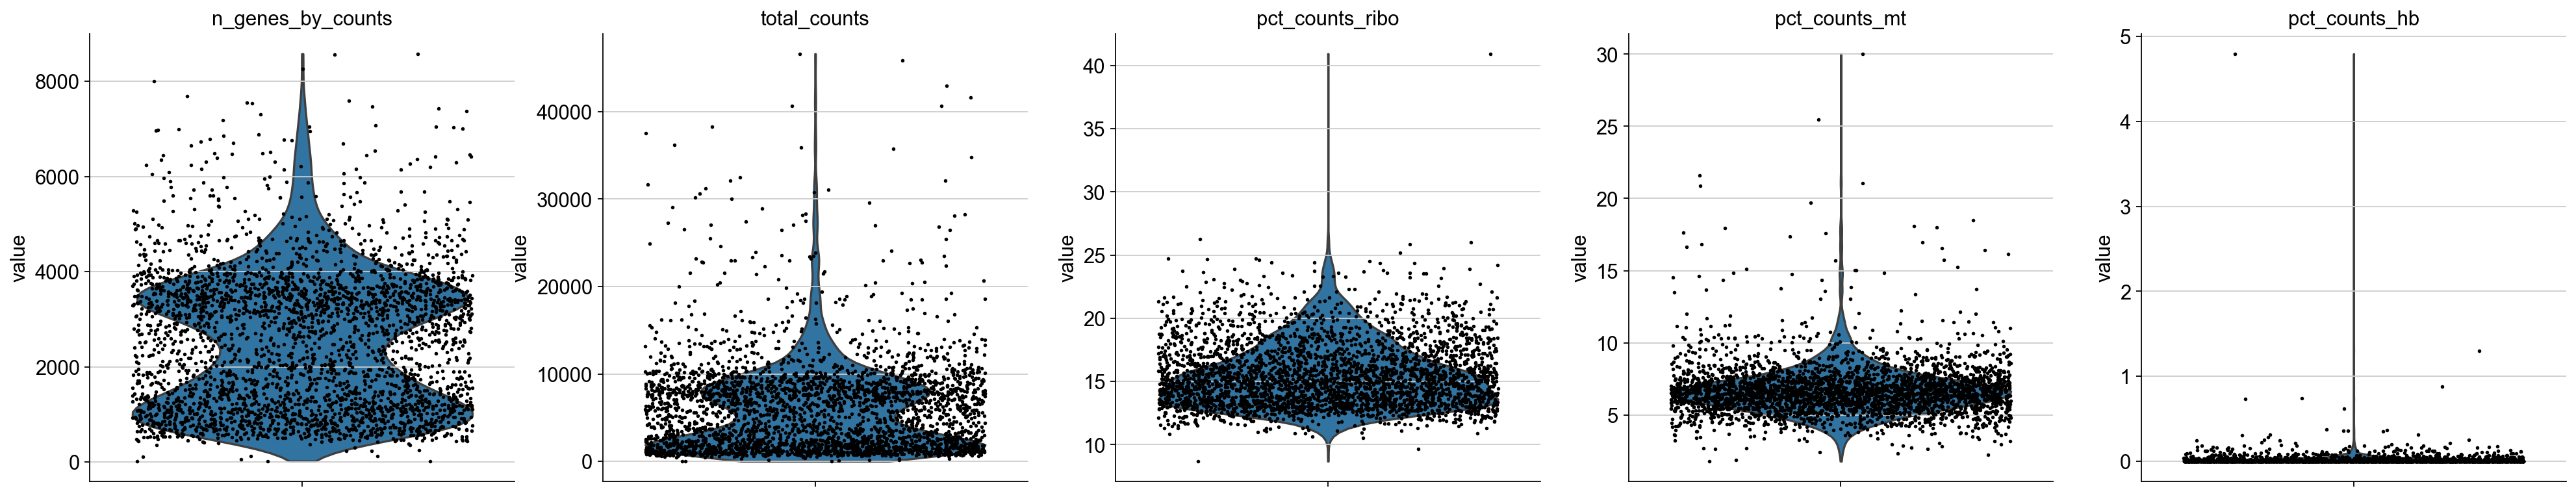

In [8]:
sc.pl.violin(adata,
             keys = ['n_genes_by_counts', 'total_counts','pct_counts_ribo', 'pct_counts_mt', 'pct_counts_hb'],
             jitter=0.4, rotation= 45, multi_panel=True, size=2.5)

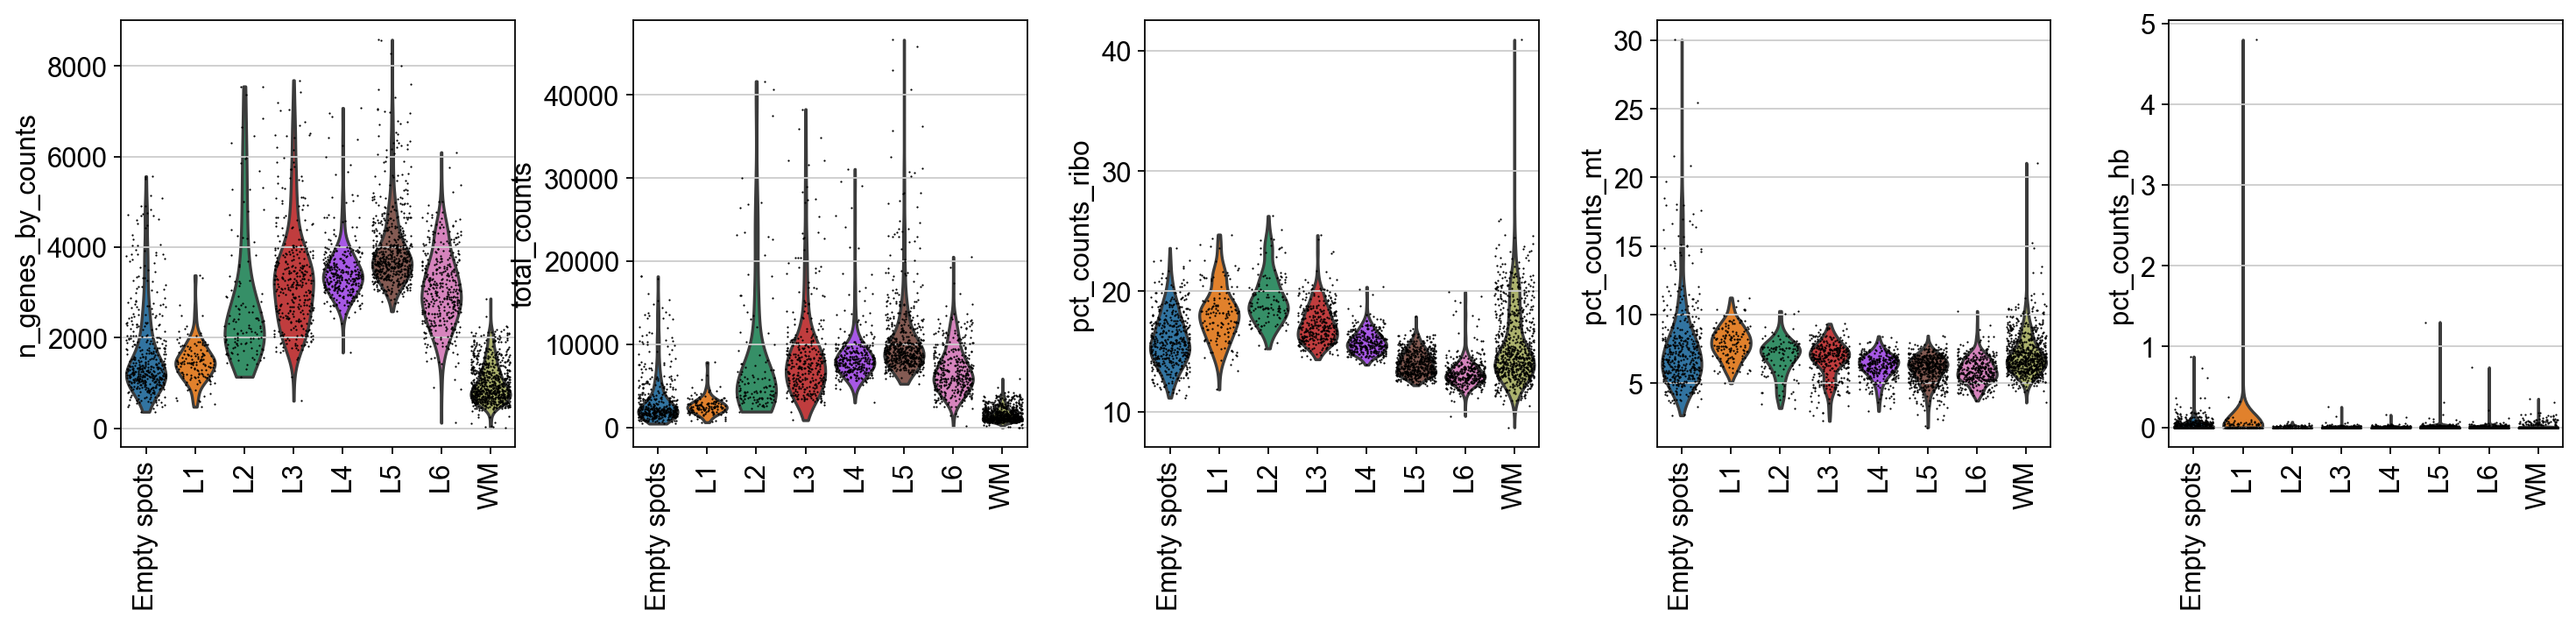

In [9]:
sc.pl.violin(adata,
             keys = ['n_genes_by_counts', 'total_counts','pct_counts_ribo','pct_counts_mt', 'pct_counts_hb'],
             jitter=0.4, groupby = 'label', rotation= 90)

Видим, что число каунтов и задетектированых генов занижено у `L1` и `WM` слоёв. Поэтому хотелось бы быть с ними аккуратнее. Хочется заметить высокий процент рибосомальных генов в `L1`

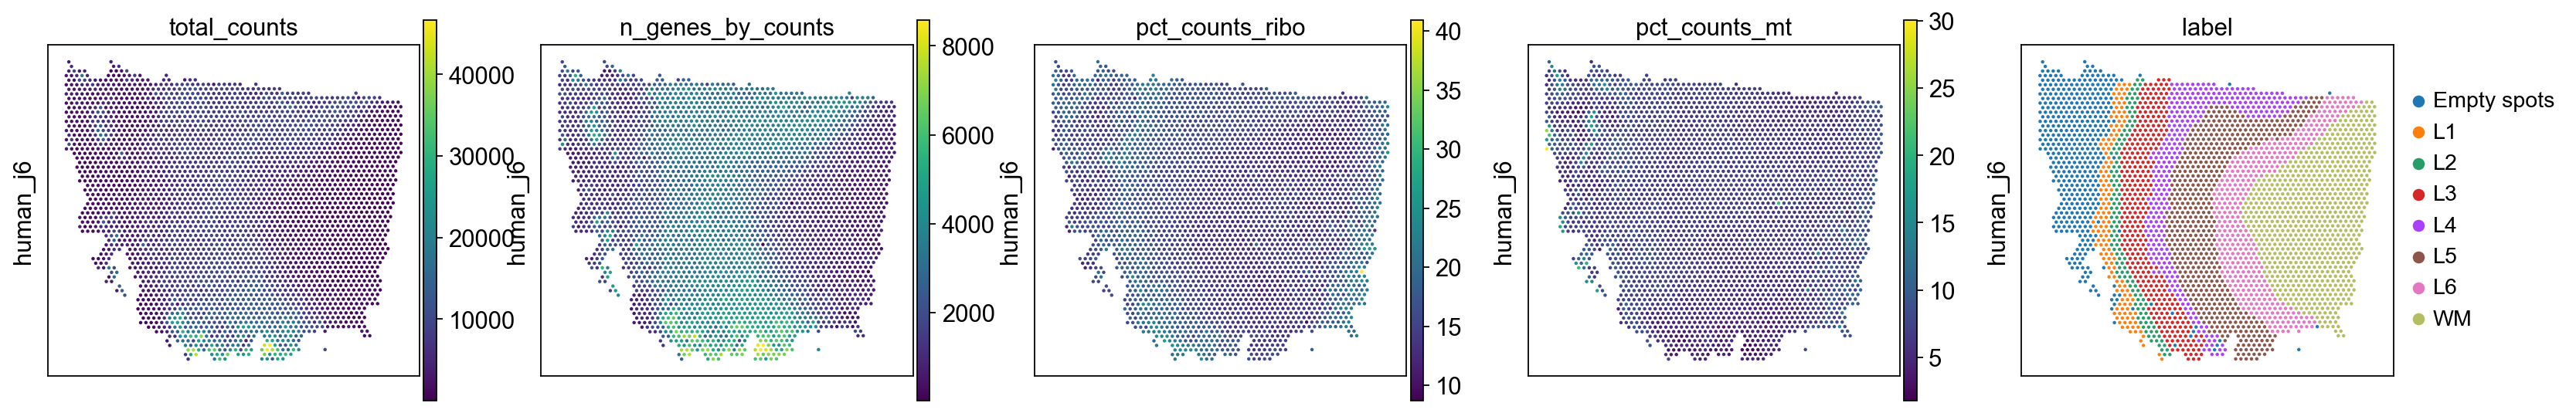

In [10]:
sq.pl.spatial_scatter(adata,
                      color = ['total_counts', 'n_genes_by_counts','pct_counts_ribo','pct_counts_mt', 'label'],
                      ncols=5, img=False, axis_label=['', file])

### Libriary size

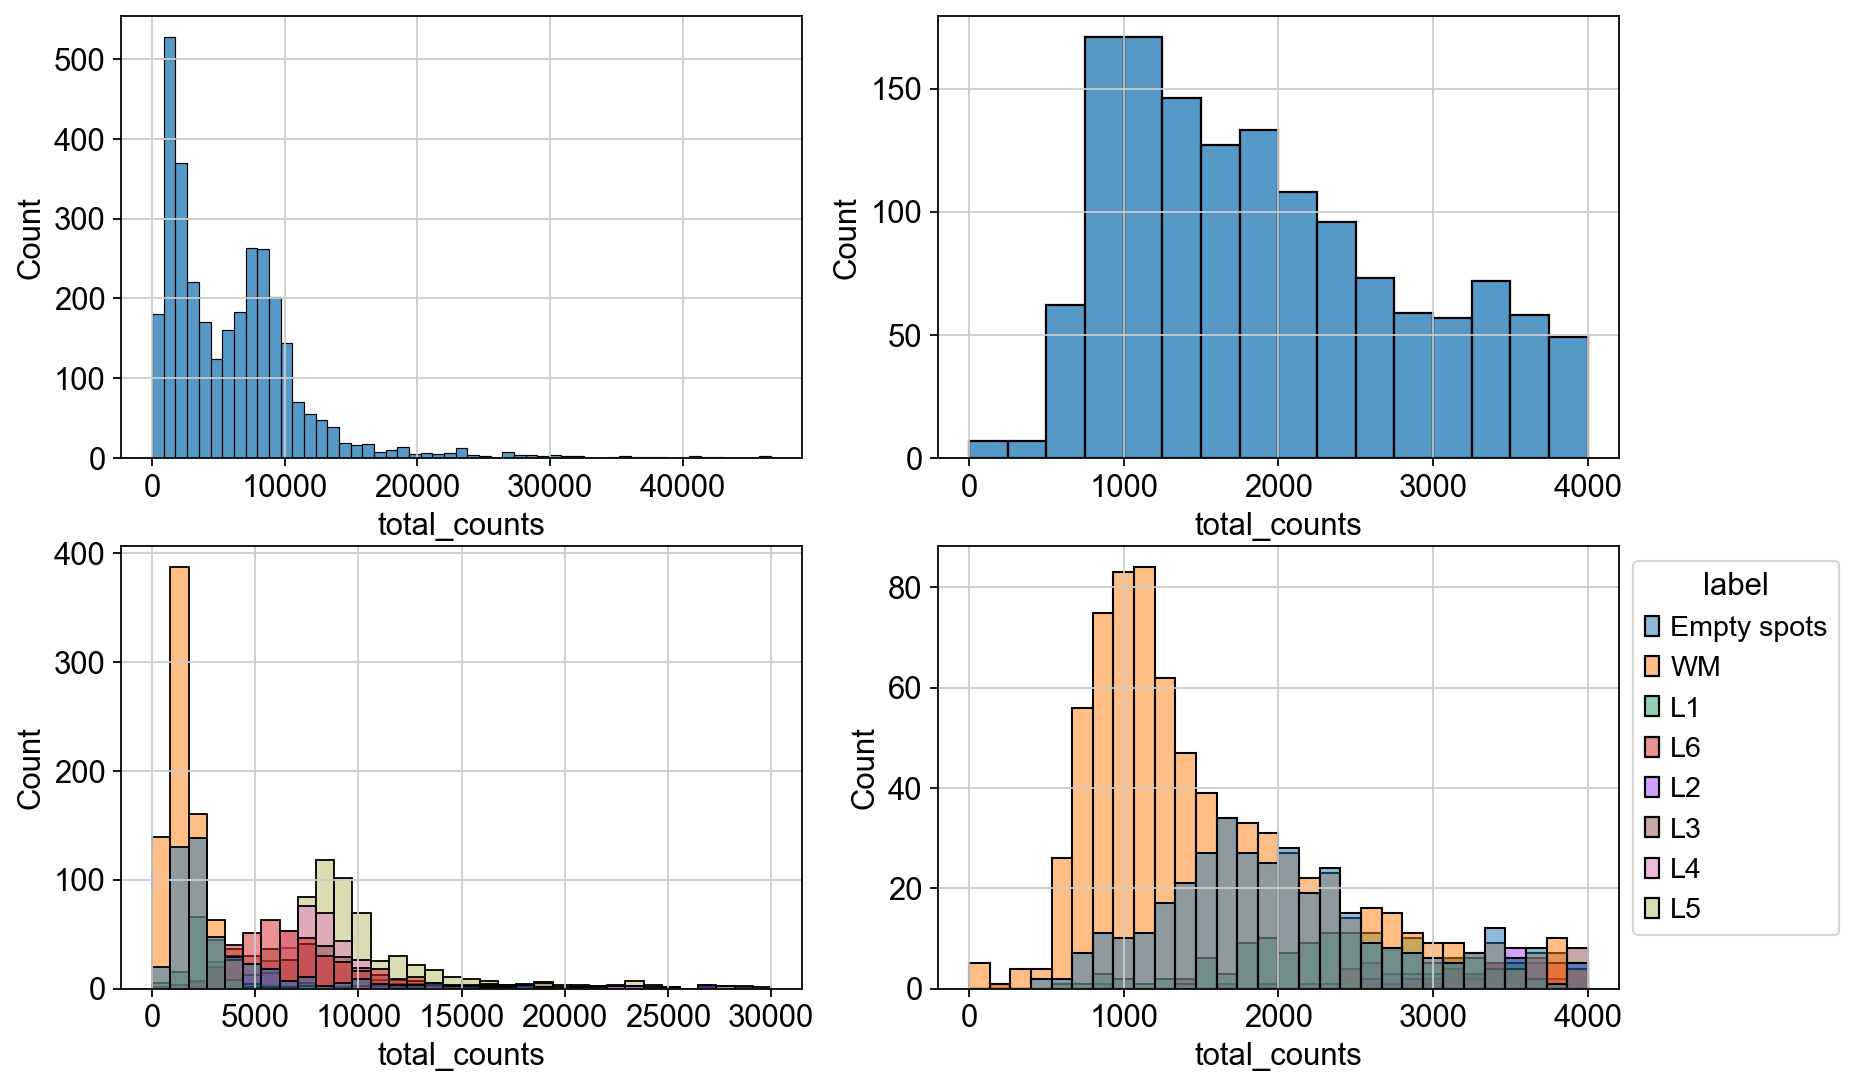

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6', 'L2', 'L3', 'L4', 'L5']
hue_order_mito = ['WM', 'L6', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='total_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 30000], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='total_counts', binrange=[0, 4000], ax=axs[0][1])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 4000], bins=30, hue='label', hue_order=hue_order, ax=axs[1][1])
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Видим, что большинство спотов низкого качества пришло из белого вещества. Посмотрим на остальные споты

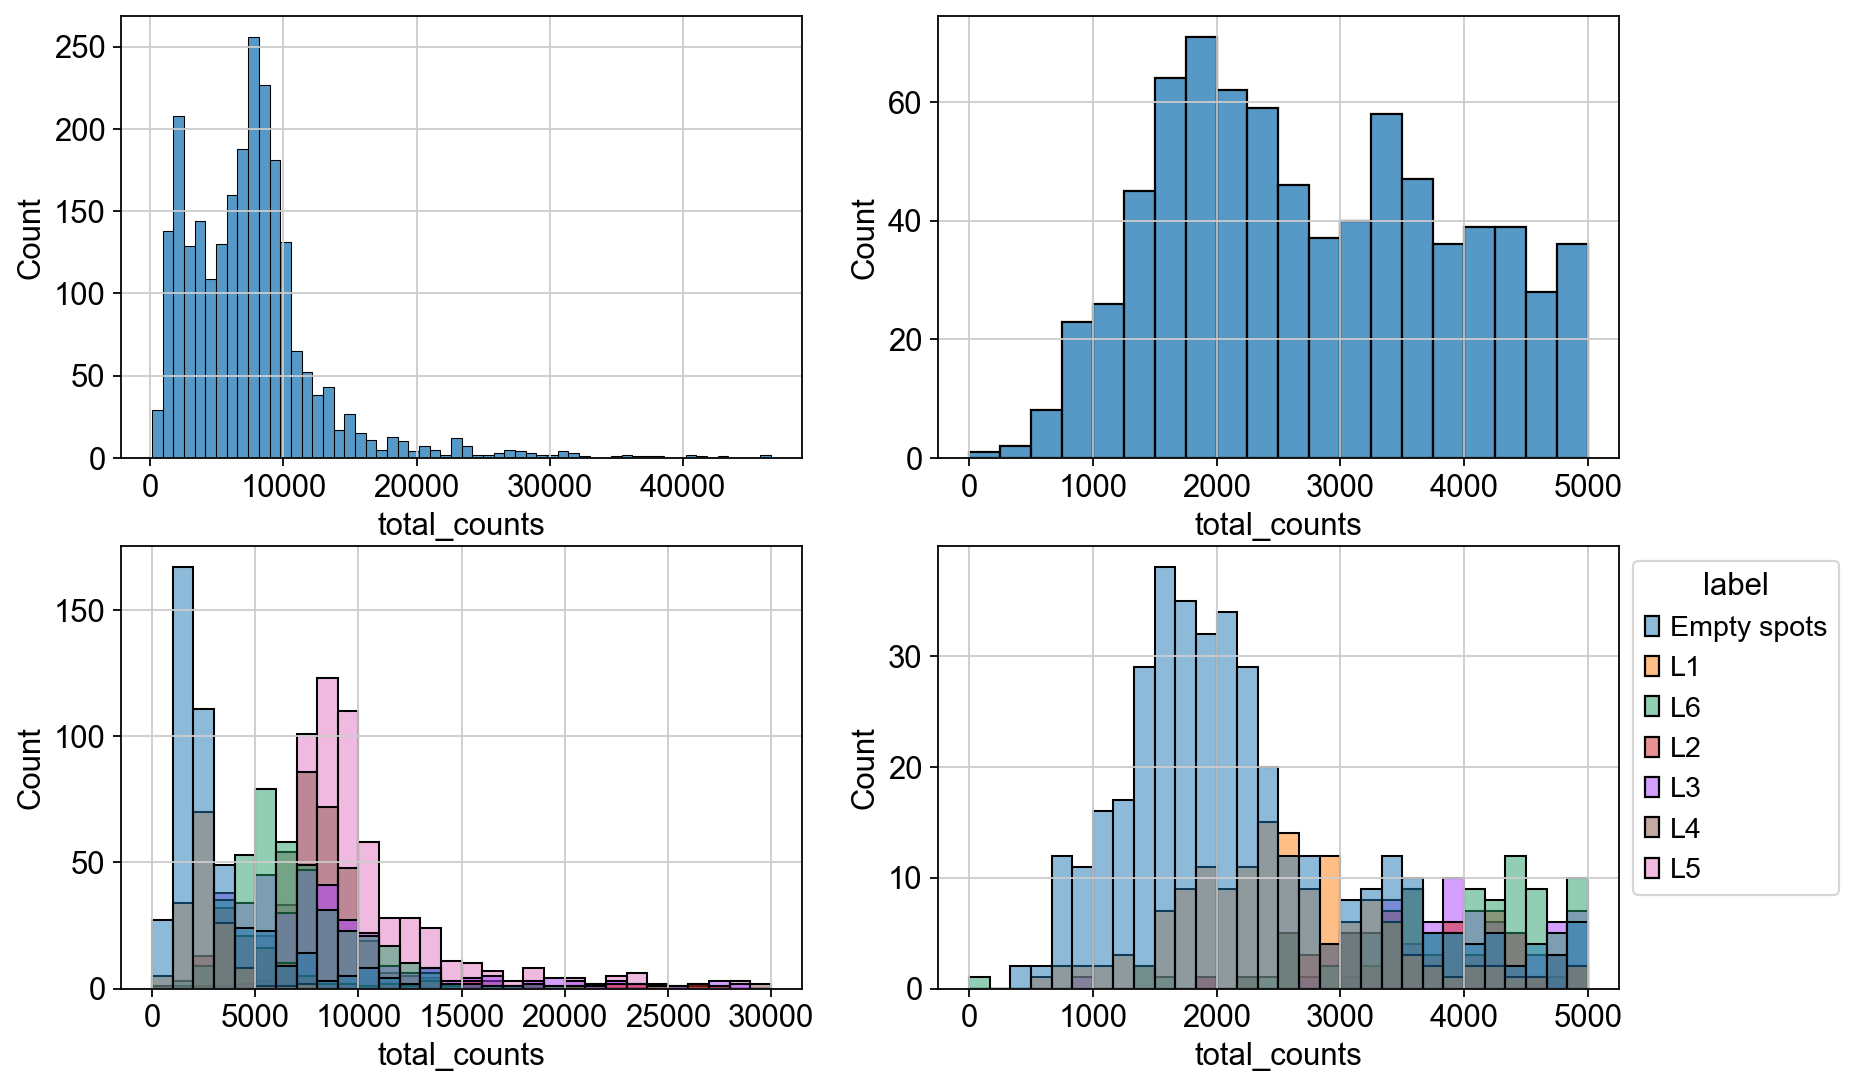

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'L1', 'L6', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs[adata.obs.label != 'WM'], x='total_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 30000], bins=30, hue='label', hue_order=hue_order, ax=axs[1][0], legend=False)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs[adata.obs.label != 'WM'], bins=20, x='total_counts', binrange=[0, 5000], ax=axs[0][1])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 5000], bins=30, hue='label', hue_order=hue_order, ax=axs[1][1])
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Выберем порог по `total counts = 2000`. Поставим порог для `WM` и для всех остальных по отдельности

In [20]:
adata.obs['qc_lib_size'] = (((adata.obs['total_counts'] > 1500) & (adata.obs.label != 'WM')) |
                            ((adata.obs['total_counts'] > 700) & (adata.obs.label == 'WM'))).astype('string')
#adata.obs['qc_lib_size'].replace({True: 'TRUE', False: 'FALSE'}, inplace=True)

vc = adata.obs.groupby('qc_lib_size')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_lib_size'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=157

label
Empty spots    89
WM             52
L1             12
L6              3
L3              1
Name: label, dtype: int64


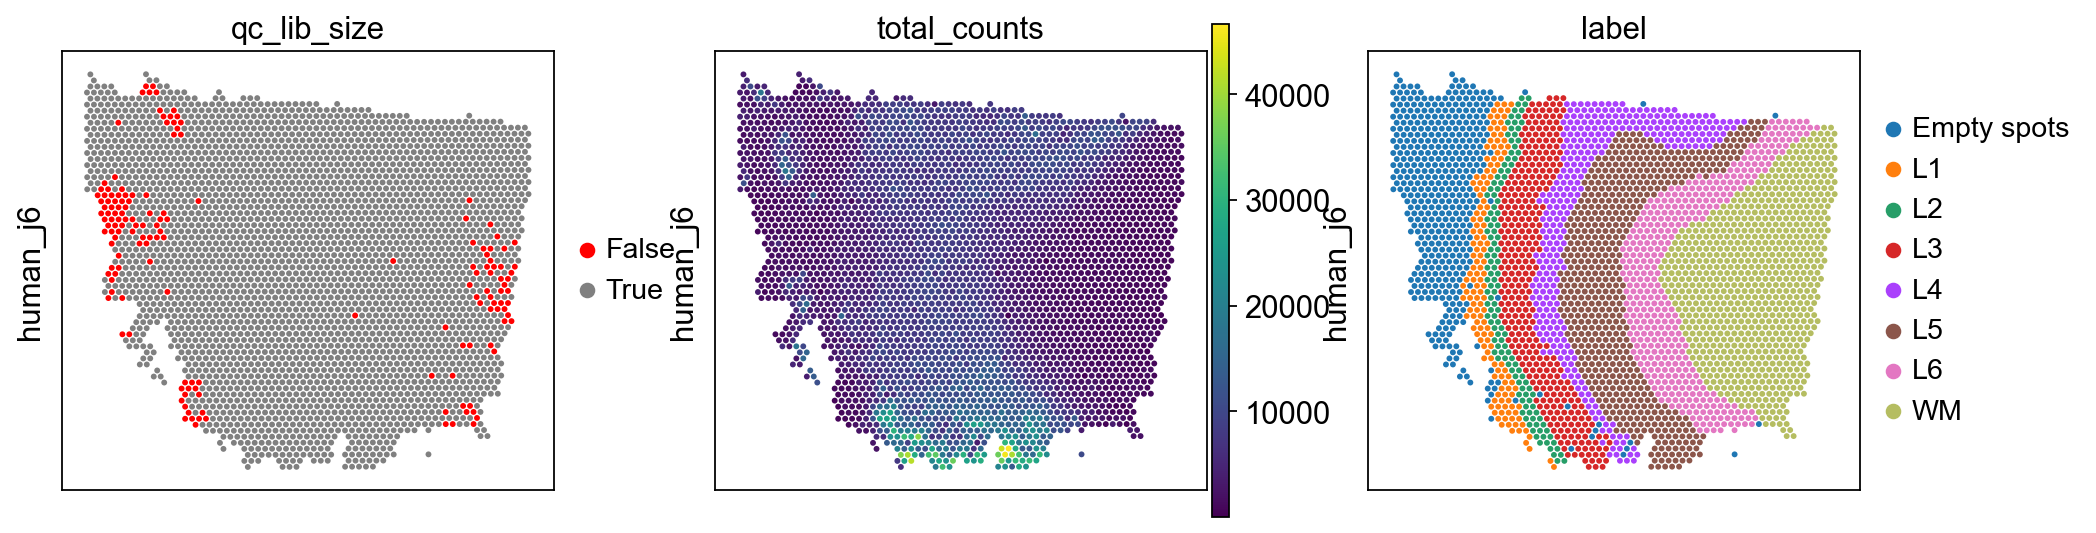

In [21]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_lib_size', 'total_counts', 'label'], img=False, axis_label=['', file], size=1.3)

### Number of expressed features

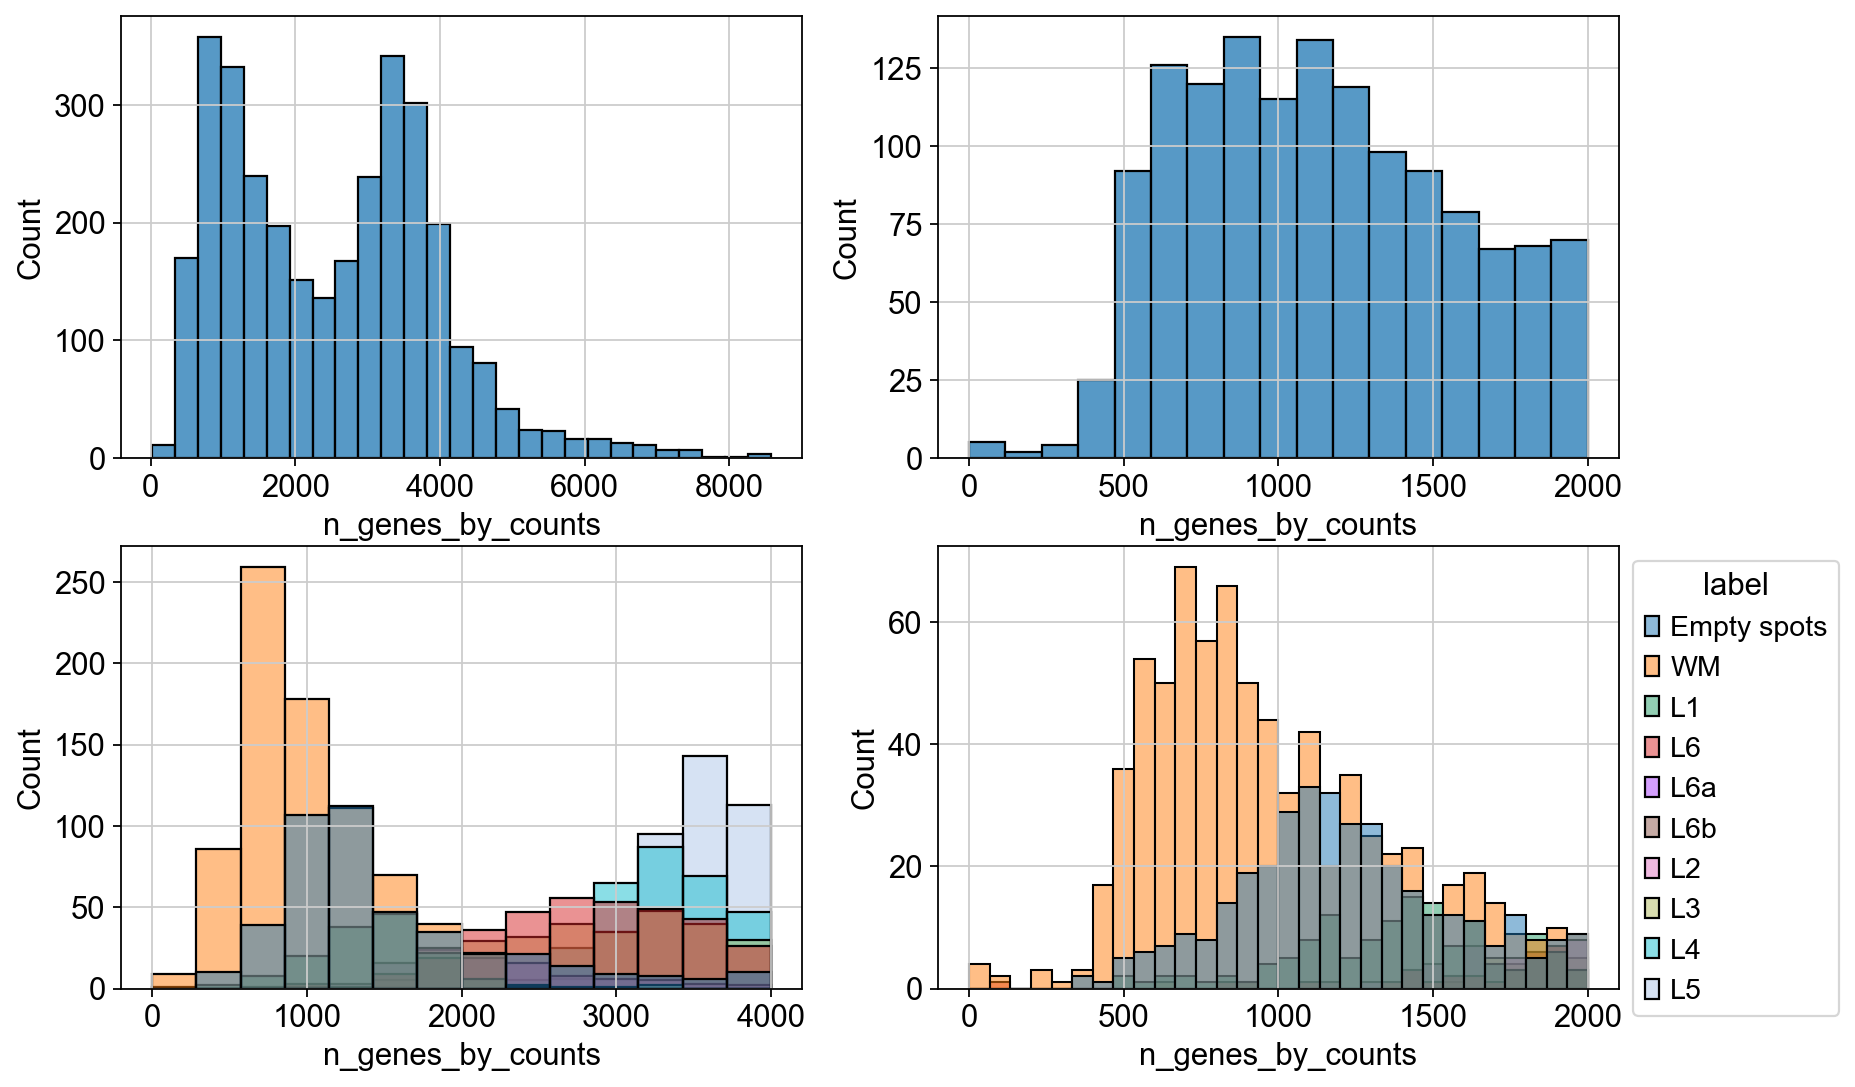

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']
hue_order_mito = ['WM', 'L6', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='n_genes_by_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 4000], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 2000], ax=axs[0][1])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 2000], bins=30, hue='label', hue_order=hue_order, ax=axs[1][1])
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Видим, что большинство спотов низкого качества пришло из белого вещества. Посмотрим на остальные споты

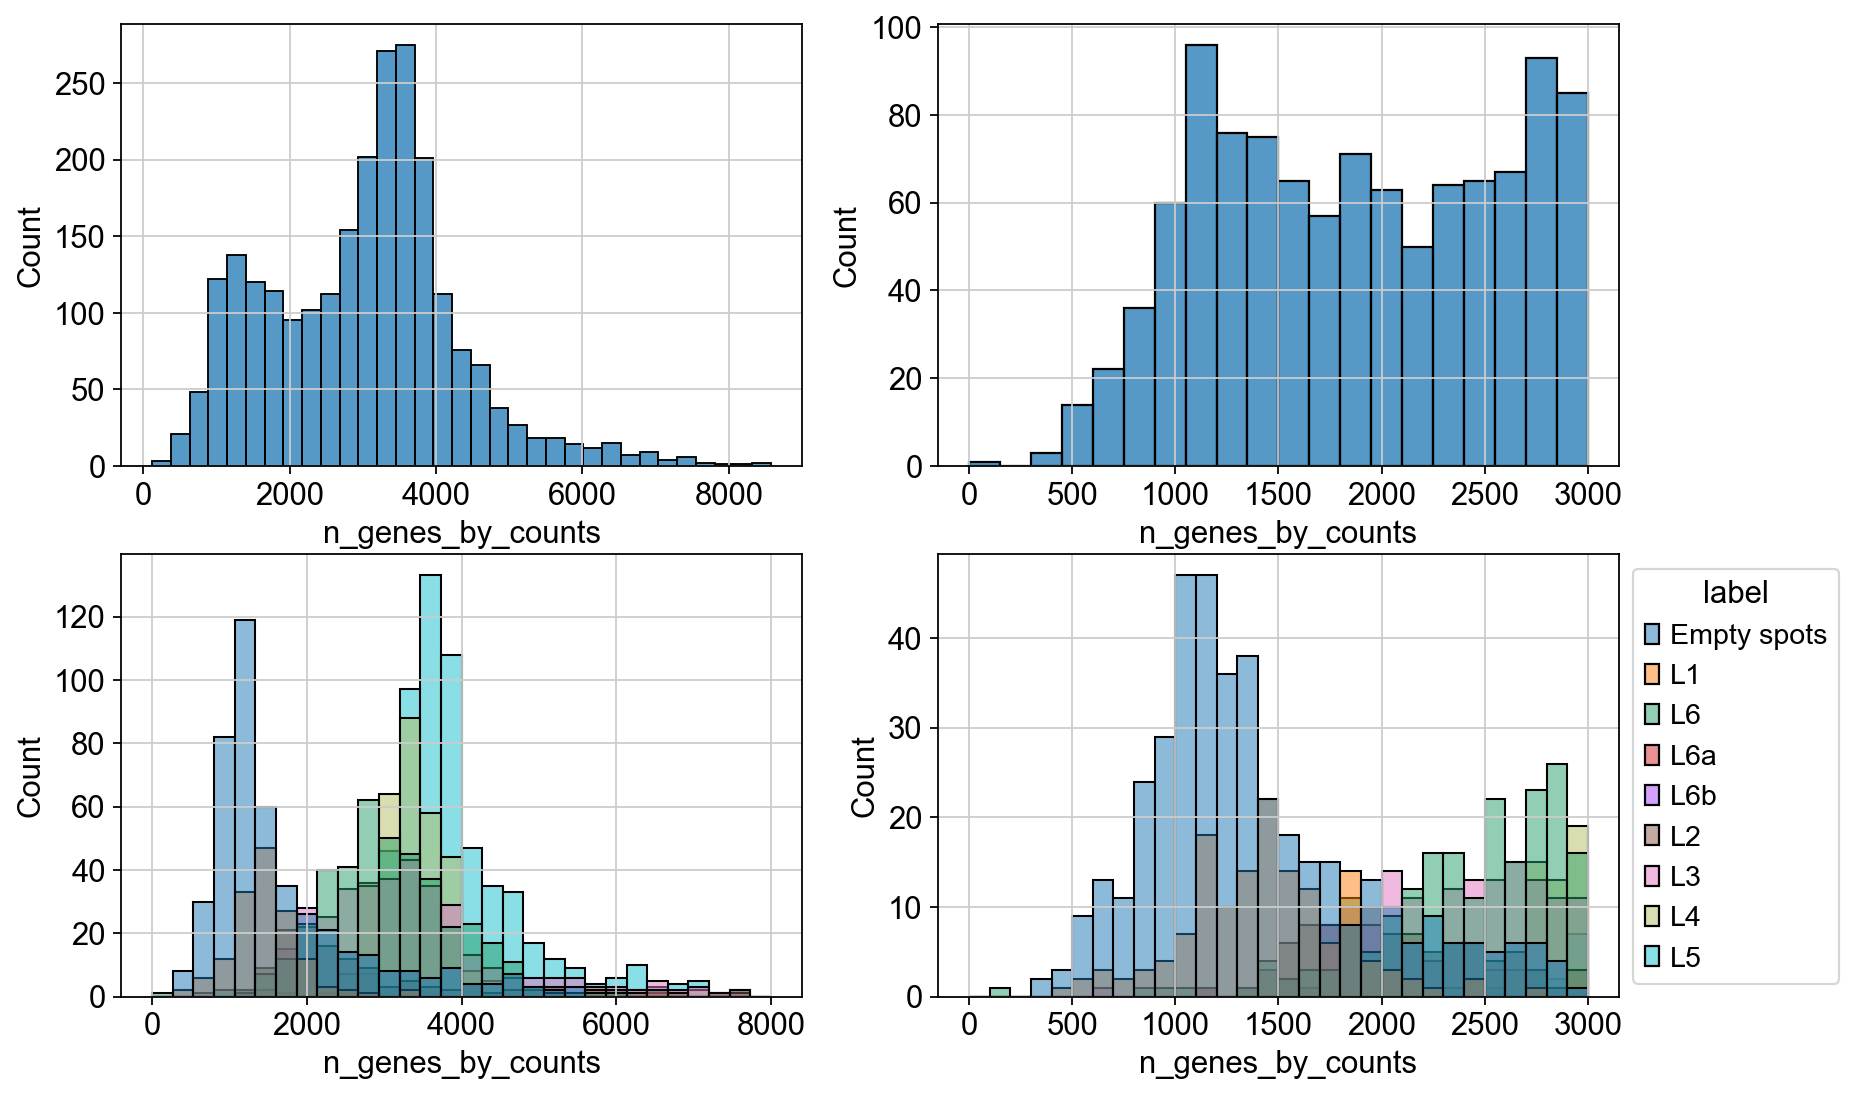

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'L1', 'L6', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs[adata.obs.label != 'WM'], x='n_genes_by_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 8000], bins=30, hue='label', hue_order=hue_order, ax=axs[1][0], legend=False)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs[adata.obs.label != 'WM'], bins=20, x='n_genes_by_counts', binrange=[0, 3000], ax=axs[0][1])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 3000], bins=30, hue='label', hue_order=hue_order, ax=axs[1][1])
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Выберем порог по `total n_genes_by_counts = 1000`. Поставим порог для `WM` и для всех остальных по отдельности

In [24]:
adata.obs['qc_n_genes'] = (((adata.obs['n_genes_by_counts'] > 1000) & (adata.obs.label != 'WM'))
                           | ((adata.obs['n_genes_by_counts'] > 500) & (adata.obs.label == 'WM'))).astype('string')
#adata.obs['qc_n_genes'].replace({True: 'True', False: 'False'}, inplace=True)
vc = adata.obs.groupby('qc_n_genes')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_n_genes'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=155

label
Empty spots    91
WM             45
L1             15
L6              3
L3              1
Name: label, dtype: int64


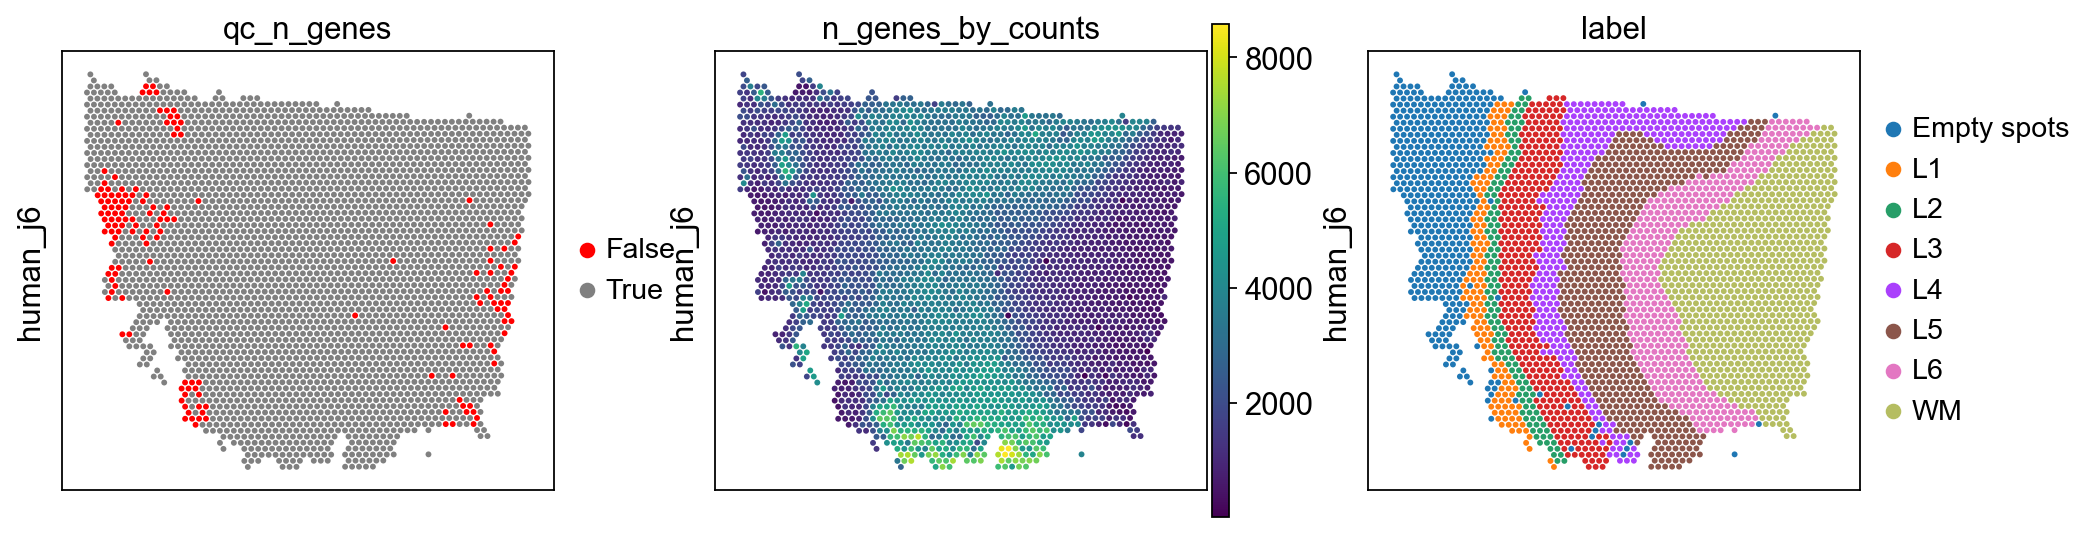

In [25]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_n_genes', 'n_genes_by_counts', 'label'], img=False, axis_label=['', file], size=1.3)

### Proportion of mitochondrial reads

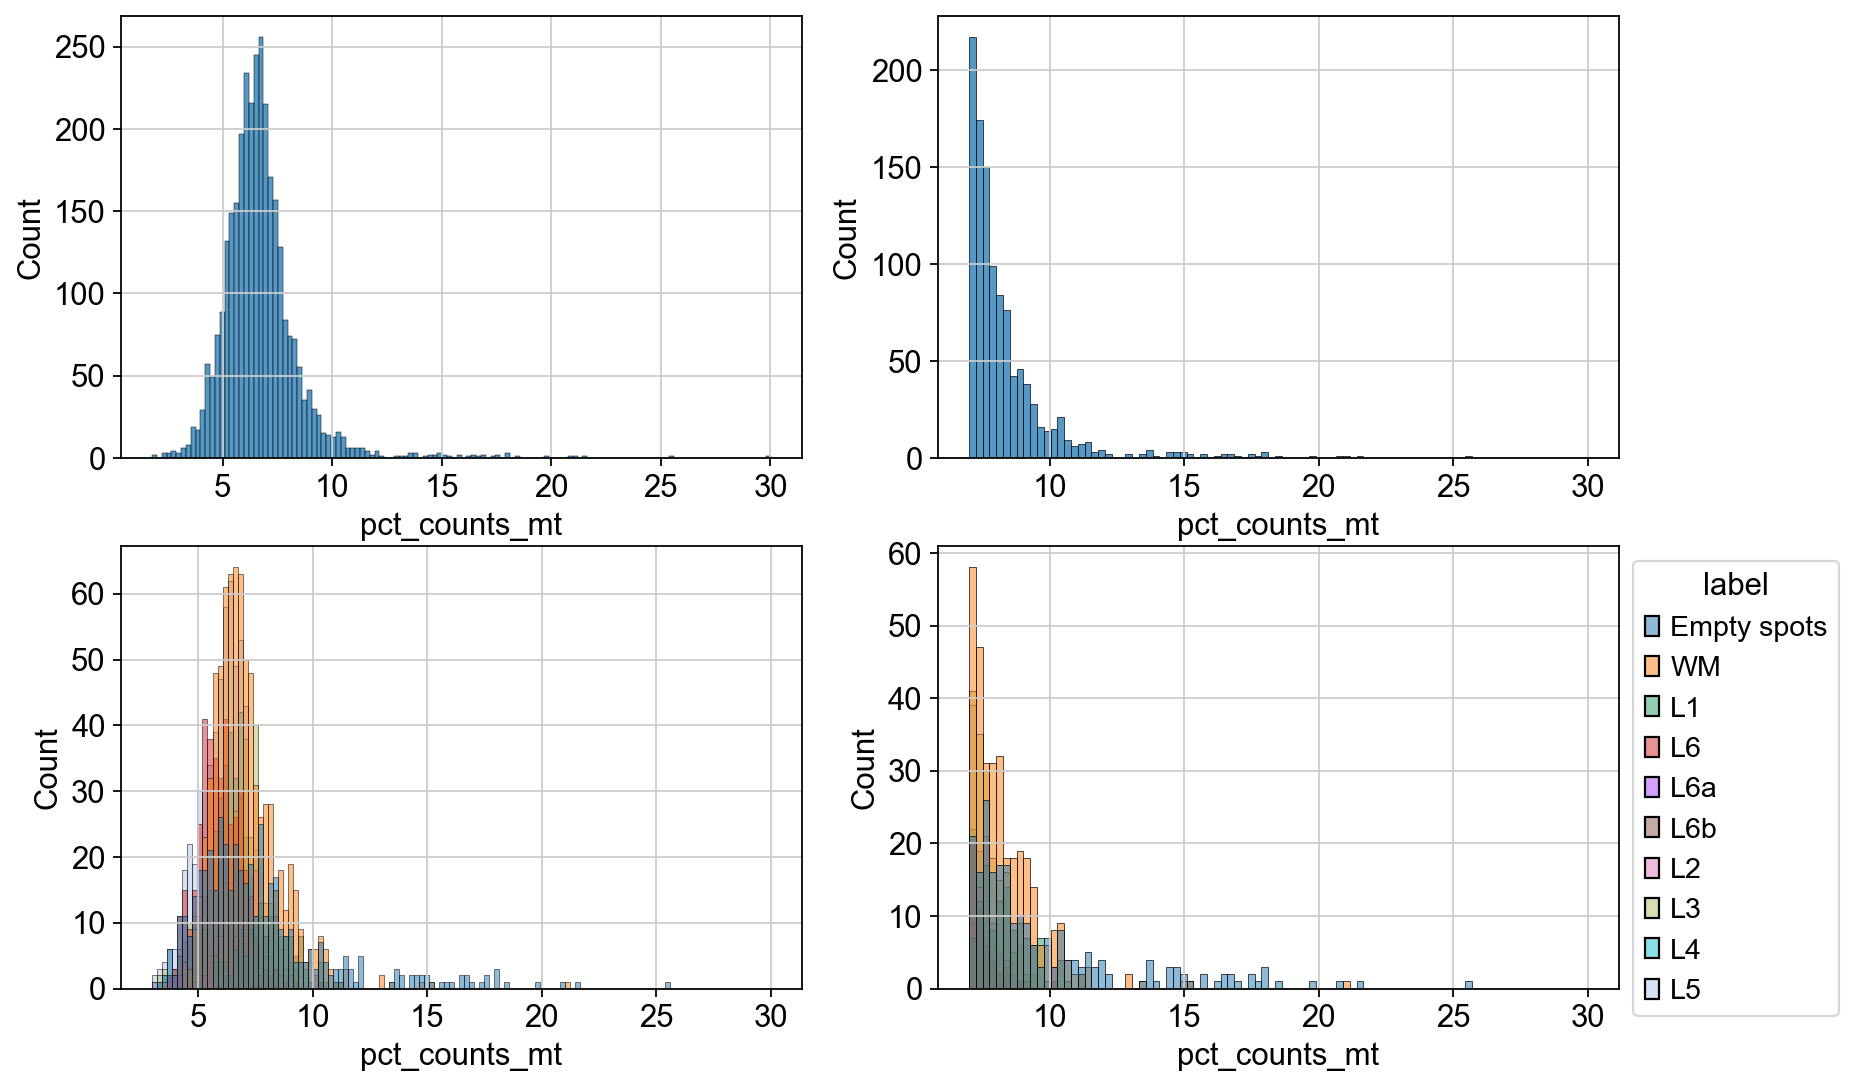

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']
hue_order_mito = ['WM', 'L6', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='pct_counts_mt', ax=axs[0][0])
sns.histplot(adata.obs, x='pct_counts_mt', binrange=[3, 30], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='pct_counts_mt', binrange=[7, 30], ax=axs[0][1])
sns.histplot(adata.obs, x='pct_counts_mt', binrange=[7, 30], hue='label', hue_order=hue_order, ax=axs[1][1])
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

In [31]:
adata.obs['qc_mt'] = (((adata.obs['pct_counts_mt'] <= 20) & (adata.obs.label != 'L1'))
                           | ((adata.obs['pct_counts_mt'] < 25) & (adata.obs.label == 'L1'))).astype('string')
#adata.obs['qc_mt'].replace({True: 'TRUE', False: 'FALSE'}, inplace=True)
vc = adata.obs.groupby('qc_mt')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_mt'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=5

label
Empty spots    4
WM             1
Name: label, dtype: int64


Кажется по митохондриям всё вполне окей

## Combined

### QC histplots

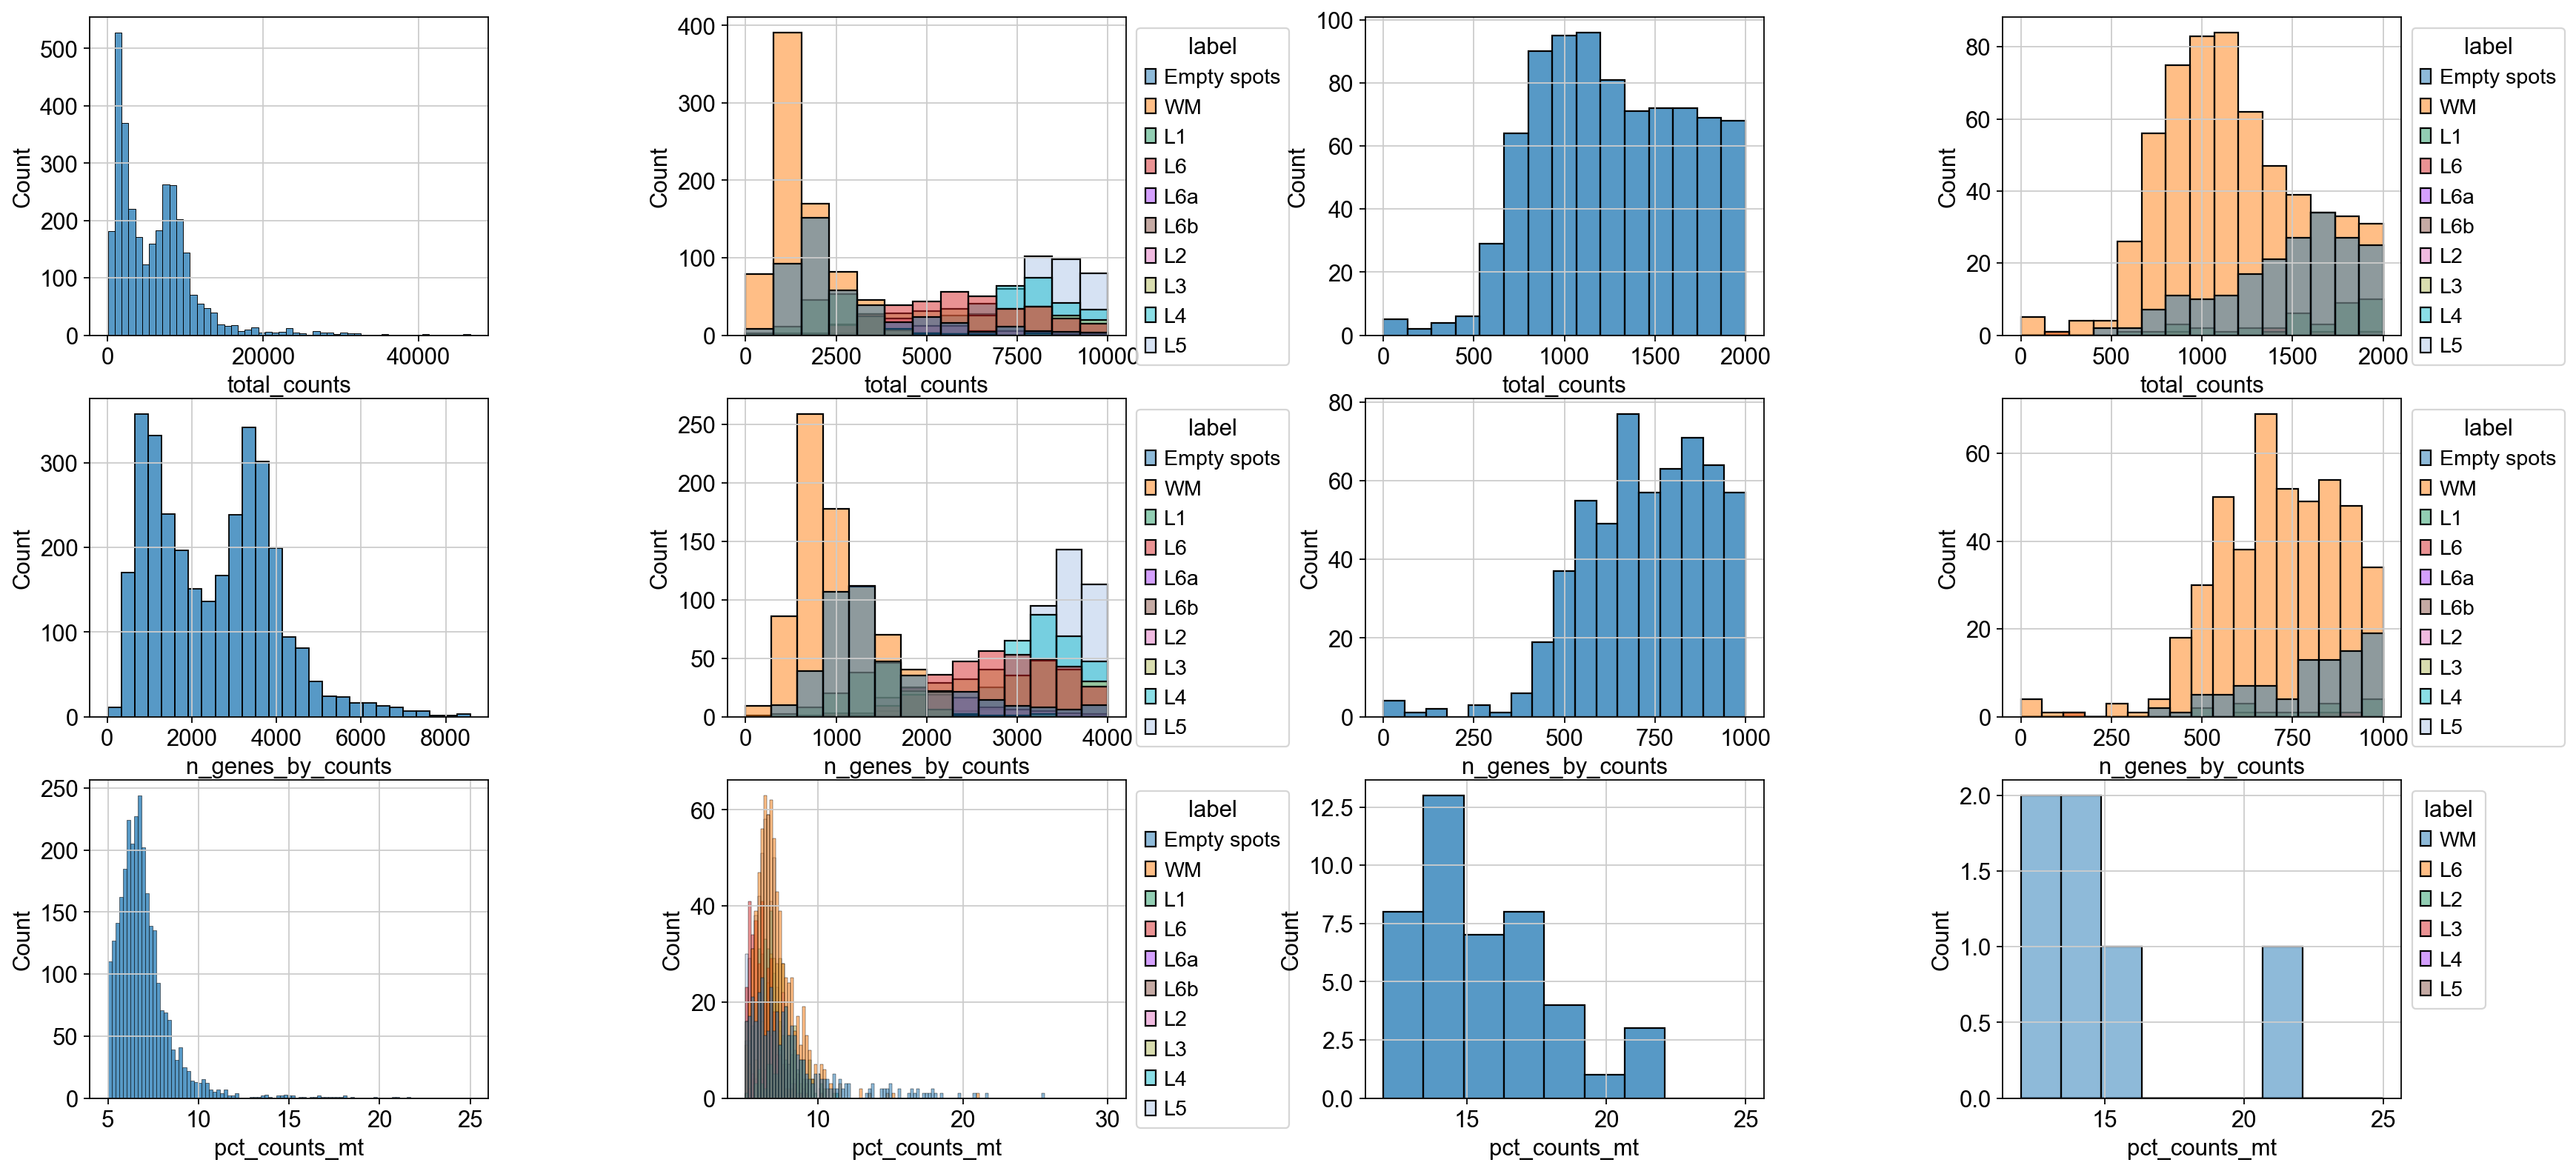

In [32]:
fig, axs = plt.subplots(3, 4, figsize=(25, 12), gridspec_kw={'wspace': 0.6, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']
hue_order_mito = ['WM', 'L6', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='total_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 10000], hue='label', hue_order=hue_order, ax=axs[0][1])
sns.move_legend(axs[0][1], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='total_counts', binrange=[0, 2000], ax=axs[0][2])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 2000], hue='label', hue_order=hue_order, ax=axs[0][3])
sns.move_legend(axs[0][3], "upper left", bbox_to_anchor=(1, 1))


sns.histplot(adata.obs, x='n_genes_by_counts', ax=axs[1][0])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 4000], hue='label', hue_order=hue_order, ax=axs[1][1])
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 1000], ax=axs[1][2])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 1000], hue='label', hue_order=hue_order, ax=axs[1][3])
sns.move_legend(axs[1][3], "upper left", bbox_to_anchor=(1, 1))


sns.histplot(adata.obs, x='pct_counts_mt', binrange=[5, 25], ax=axs[2][0])
sns.histplot(adata.obs, x='pct_counts_mt', binrange=[5, 30], hue='label', hue_order=hue_order, ax=axs[2][1])
sns.move_legend(axs[2][1], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='pct_counts_mt', binrange=[12, 25], ax=axs[2][2])
sns.histplot(adata.obs, x='pct_counts_mt', binrange=[12, 25], hue='label', hue_order=hue_order_mito, ax=axs[2][3])
sns.move_legend(axs[2][3], "upper left", bbox_to_anchor=(1, 1))

### QC spatial_scatter

In [33]:
d = {'True': True, 'False': False}
adata.obs['qc_lib_size'] = adata.obs['qc_lib_size'].astype(object).replace(d)
adata.obs['qc_n_genes'] = adata.obs['qc_n_genes'].astype(object).replace(d)
adata.obs['qc_mt'] = adata.obs['qc_mt'].astype(object).replace(d)

In [34]:
adata.obs['qc_good_spots'] = (adata.obs.qc_lib_size * adata.obs.qc_n_genes * adata.obs.qc_mt).astype('string')
vc = adata.obs.groupby('qc_good_spots')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_good_spots'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=176

label
Empty spots    101
WM              56
L1              15
L6               3
L3               1
Name: label, dtype: int64


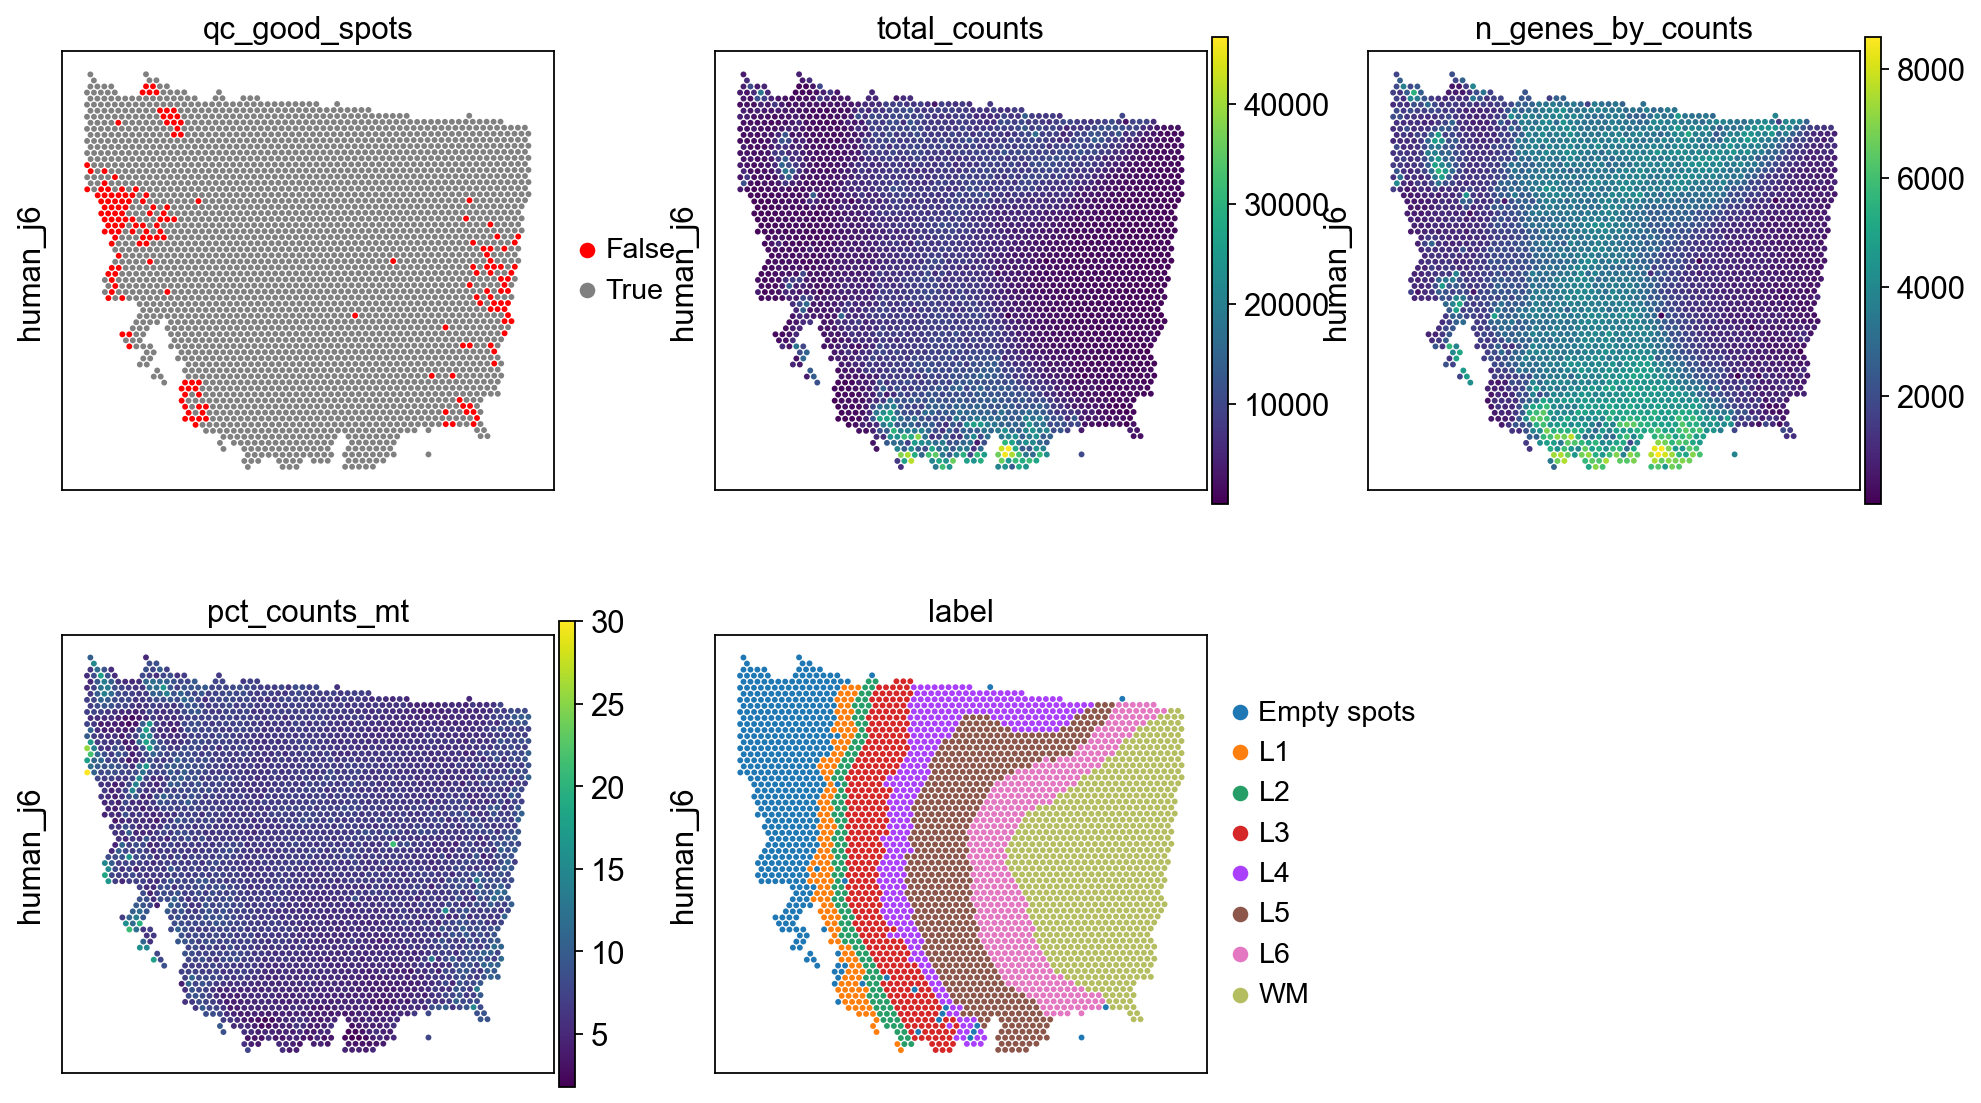

In [35]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_good_spots',  'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'label'],
                          img=False, axis_label=['', file], size=1.3, ncols=3)

### QC scatter plots

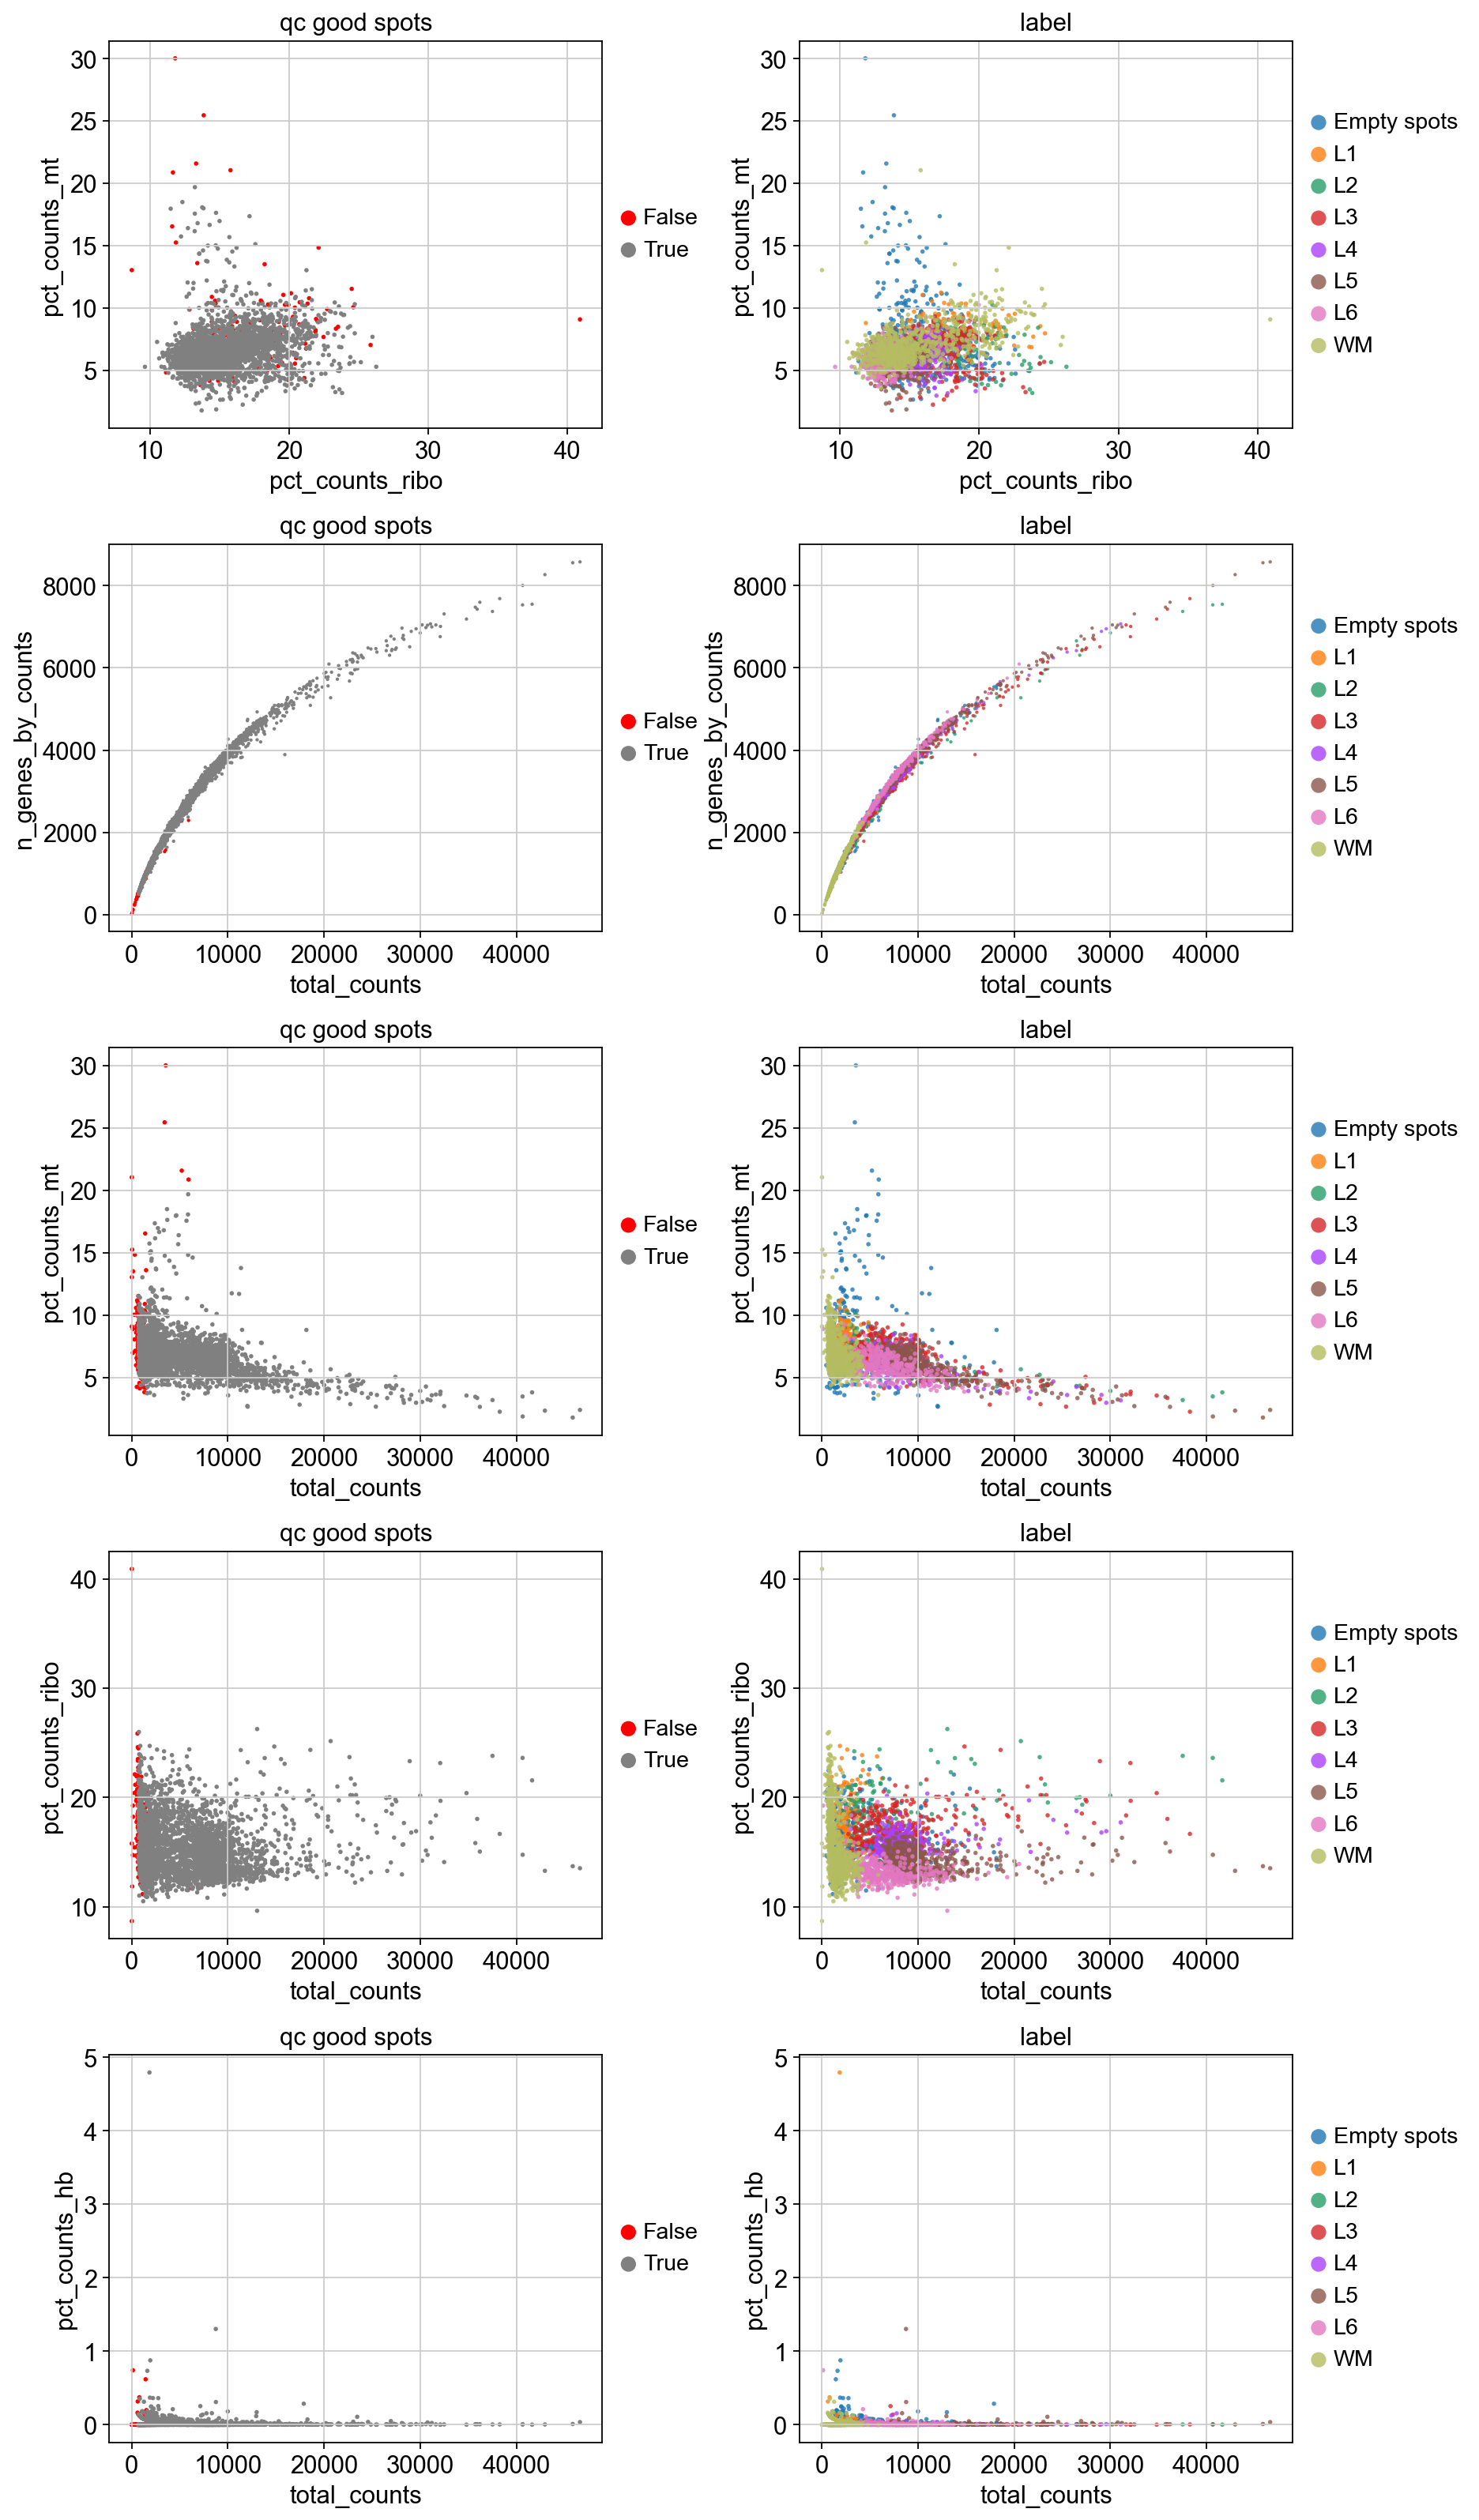

In [36]:
fig, ax = plt.subplots(5, 2, figsize=(12, 25), gridspec_kw={'wspace': 0.4, 'hspace': 0.3})
alpha = 0.8

sc.pl.scatter(adata, x='pct_counts_ribo', y='pct_counts_mt', color="qc_good_spots", ax=ax[0][0], show=False, size=25)
sc.pl.scatter(adata, x='pct_counts_ribo', y='pct_counts_mt', color="label", ax=ax[0][1], show=False, size=25, alpha=alpha)

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="qc_good_spots", ax=ax[1][0], show=False, size=15)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="label", ax=ax[1][1], show=False, alpha=alpha, size=15)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="qc_good_spots", ax=ax[2][0], show=False, size=25)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="label", ax=ax[2][1], show=False, alpha=alpha, size=25)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color="qc_good_spots", ax=ax[3][0], show=False, size=25)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color="label", ax=ax[3][1], show=False, alpha=alpha, size=25)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb', color="qc_good_spots", ax=ax[4][0], show=False, size=25)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb', color="label", ax=ax[4][1], show=False, alpha=alpha, size=25)

plt.show()

### Cохраним отфильтрованые споты (без пустых)

In [37]:
good_spots = adata.obs[(adata.obs.qc_good_spots == 'True') & (adata.obs.label != 'Empty spots')].index

In [38]:
adata_filtered = adata[good_spots].copy()

### PCA

In [39]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:24)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


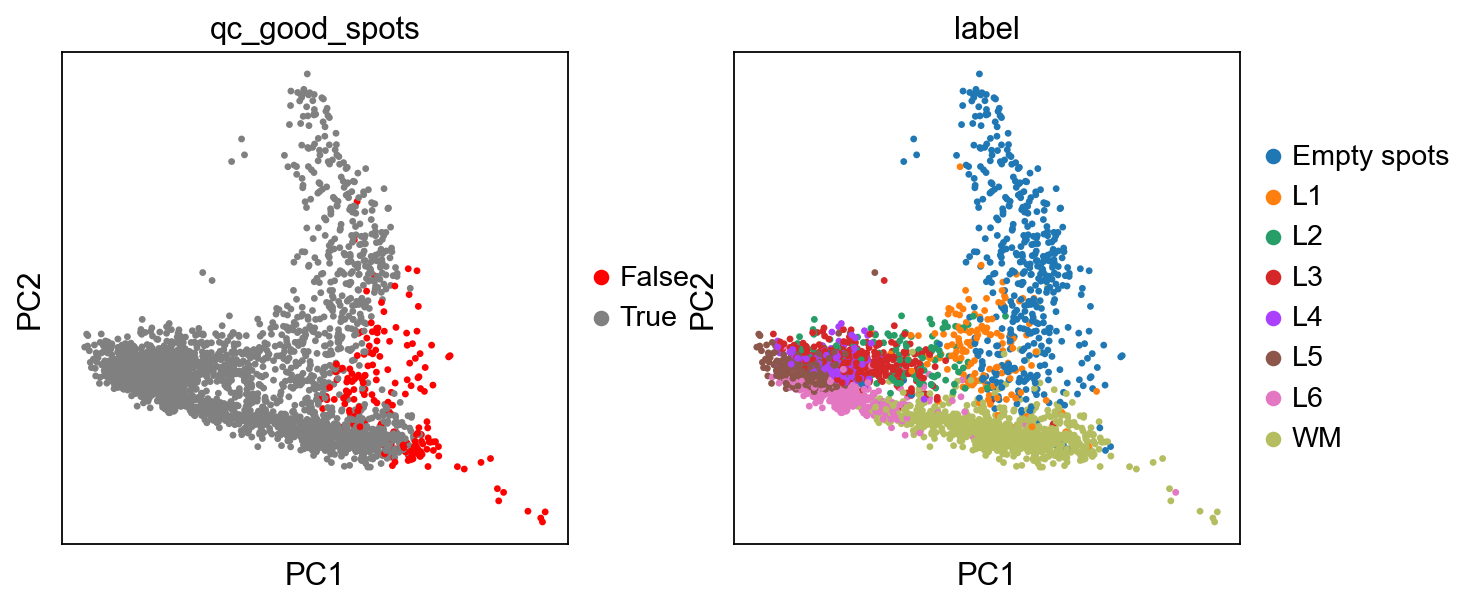

In [40]:
sc.pl.pca(adata, color=['qc_good_spots', 'label'])

Кажется вот этот жёлтый спот в гуще нужно тоже выкидывать

## Сохраним в .h5ad

In [41]:
adata_filtered.obs.drop(['qc_lib_size','qc_n_genes', 'qc_good_spots', 'qc_mt'], axis=1, inplace=True)

In [42]:
adata_filtered.obs.head()

in_tissue  array_row  array_col label sample_id  \
AAACAAGTATCTCCCA-1          1         50        102    WM  human_j6   
AAACATTTCCCGGATT-1          1         61         97    WM  human_j6   
AAACCCGAACGAAATC-1          1         45        115    WM  human_j6   
AAACCGGGTAGGTACC-1          1         42         28    L2  human_j6   
AAACCGTTCGTCCAGG-1          1         52         42    L3  human_j6   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACAAGTATCTCCCA-1                910        1342.0             98.0   
AAACATTTCCCGGATT-1               1818        3208.0            167.0   
AAACCCGAACGAAATC-1                717        1036.0             79.0   
AAACCGGGTAGGTACC-1               1770        3151.0            210.0   
AAACCGTTCGTCCAGG-1               3480        8554.0            598.0   

                    pct_counts_mt  total_counts_hb  pct_counts_hb  \
AAACAAGTATCTCCCA-1       7.302534              1.0       0.074516   
AAACATTTCCCGGATT-1       5.205736              0.0       0.000000   
AAACCCGAACGAAATC-1       7.625483              0.0       0.000000   
AAACCGGGTAGGTACC-1       6.664551              0.0       0.000000   
AAACCGTTCGTCCAGG-1       6.990881              0.0       0.000000   

                    total_counts_ribo  pct_counts_ribo  
AAACAAGTATCTCCCA-1              193.0        14.381520  
AAACATTTCCCGGATT-1              425.0        13.248129  
AAACCCGAACGAAATC-1              204.0        19.691120  
AAACCGGGTAGGTACC-1              520.0        16.502697  
AAACCGTTCGTCCAGG-1             1311.0        15.326163

In [43]:
os.makedirs('../results/filtered_samples', exist_ok=True)
os.makedirs('../results/filtered_samples/human', exist_ok=True)
adata_filtered.write_h5ad(f'../results/filtered_samples/human/{file}.h5ad')